In [1]:
import time
import os
import sys
import csv
import math
import json
import shutil
import random
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io.image import read_image
import torch.profiler
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models

sys.path.insert(1, 'utils')
from HelperFunctions import *
from pytorch_resnet import *
from randaugment import RandAugmentMC
from visualiser import salience
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub

cpu_device = torch.device("cpu:0")

# from efficientnet_lite import build_efficientnet_lite

In [2]:

basepath = 'T:/Haematology FYP/hematology/'
colour = 'Green'
config = dict(
        epochs=20,
        classes=['Basophil','Eosinophil','Lymphocyte','Monocyte','Neutrophil'],
        image_size=160,
        batch_size=64,
        valid_batch_size = 12,
        batch_size_latency=1,
        save = 'Models/baseline/temp/'+ colour,
        save_suffix = '_profiling_'+colour,
        lr = 1.5e-4,
        patience=15,
        delta=0.001,
        lr_lambda = 0.9,
        transforms = dict(n=15,m=10,norm=None),
        architecture_list = [#'resnet18',
                            # 'resnet34',
                            # 'resnet50', 
                            # 'regnet_y_400mf',
                            #'mobilenet_v3_small'
                            'mobilenet_v2',
                            # 'shufflenet_v2_x0_5',
                            # 'regnet_x_400mf',
                            # 'regnet_x_800mf',
                            # 'regnet_y_400mf',
                            # 'regnet_y_800mf'
                            ],
        data_path = basepath + 'Data/WBC_Classification_3172_c/',
        tags = [colour,'Training','v3'],
        profiling = False,
        num_workers=6
    )

99% certainty the cell is a Neutrophil


<ipython-input-3-bd6703d71d96>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  salience(model, img, hue=-0.15).show() # hue=-0.15


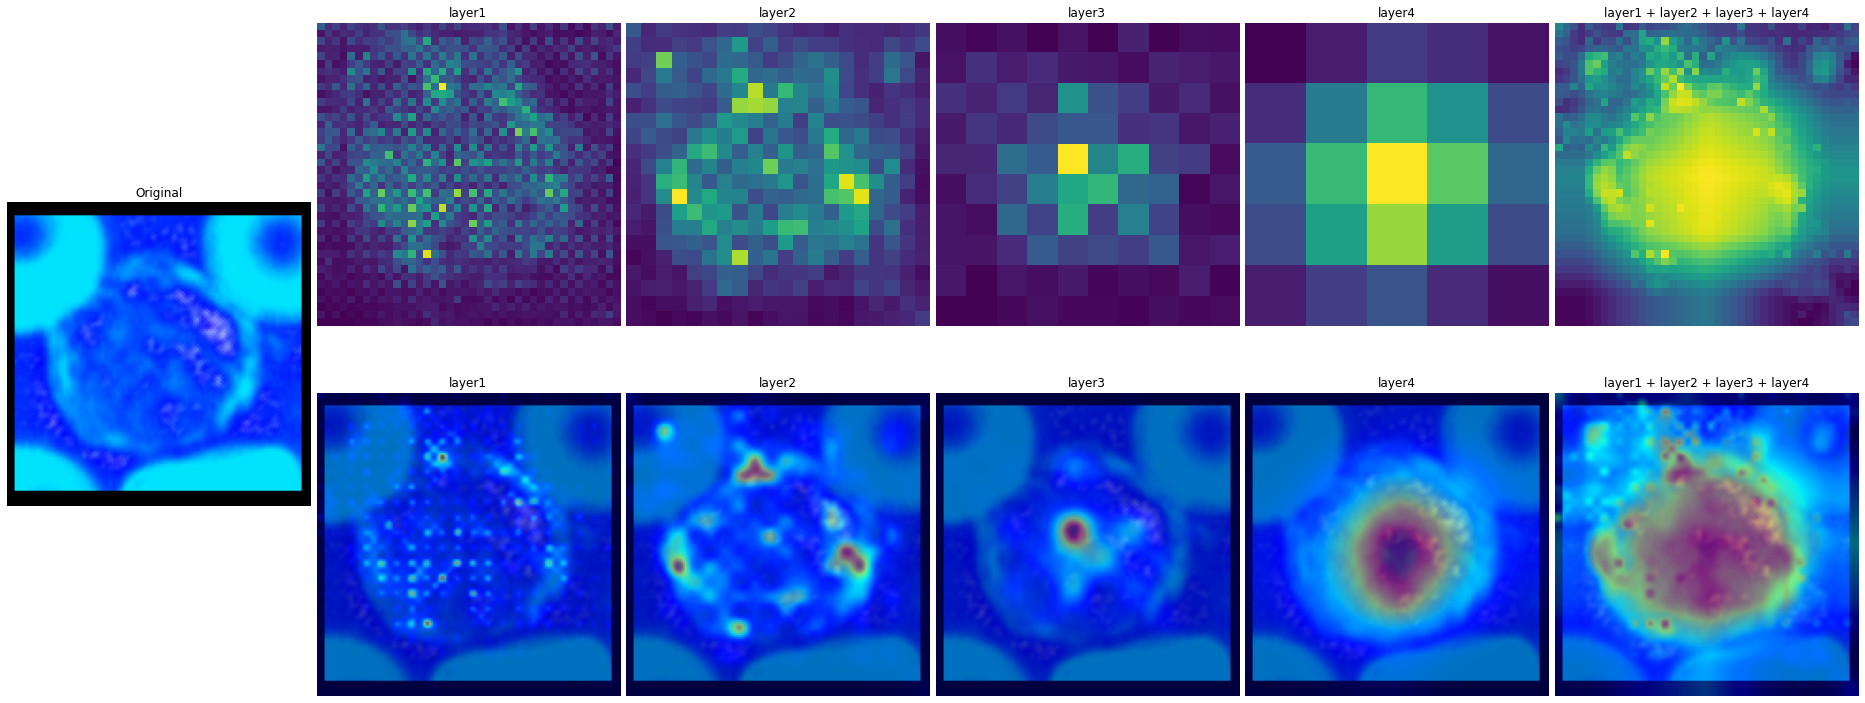

In [3]:
model = create_model('resnet18', cpu_device).eval()
check_point = torch.load(basepath + 'Models/baseline/temp/Purpleresnet18_profiling_Purple.pt')
model.load_state_dict(check_point['model_state_dict'])

img = read_image(basepath+'samples/4/(16).png')
salience(model, img, hue=-0.15).show() # hue=-0.15
#https://github.com/frgfm/torch-cam